<h1>AI Face Mask Detector, Project Assignment Part-I.</h1>
<h5>COMP 6721 Applied Artificial Intelligence</h5>
<ul>
<li>40155790 - Sivakumaran Malli Janardhanan</li>
<li> - Saghana Mahesh</li>
<li>40163063 - Shubhang Khattar</li>
</ul>

<hr>
<p>Goal is to to develop a Deep Learning Convolutional Neural Network (CNN) using PyTorch and train it to recognize five different classes:</p>
<ol>
<li>Person without a face mask</li>
<li>Person with a cloth face mask</li>
<li>Person with a surgical mask</li>
<li>Person with a N95 mask</li>
<li>Person with a N95 mask that has a valve.</li>
</ol>

Importing the packages.


In [477]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix , classification_report

Declaring constants

In [463]:
dataSet_Path = 'Project_Dataset/'
learning_rate = 0.01
epochs = 30
use_saved_model = False

In [496]:
def data_loader(path,batch,test_data_index,validation_data_index):

    torch.manual_seed(0)
    transformer = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.225, 0.225, 0.225])])

    all_data = ImageFolder(root=path, transform=transformer)

    class_labels_dict = {}
    class_names = all_data.classes
    label_count = 0
    for label_name in all_data.classes:
        class_labels_dict[label_count] = label_name
        label_count += 1

    mask_counts = dict()

    for path,label in all_data.imgs:

        count = mask_counts.get(label,0) + 1
        mask_counts[label] = count

    data_test_size = math.floor(test_data_index*len(all_data))
    data_train_size =  len(all_data) - data_test_size
    data_validation_size = math.floor(validation_data_index * data_train_size)
    data_train_size = data_train_size - data_validation_size

    data_train_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[:data_train_size])
    data_validation_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[data_train_size:data_train_size+data_validation_size])
    data_test_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[(data_train_size+data_validation_size):])

    data = {'0':mask_counts[0], "1":mask_counts[1], '2':mask_counts[2],
            "3":mask_counts[3], "4" : mask_counts[4]}
    courses = list(data.keys())
    values = list(data.values())
    plt.bar(courses, values, color ='maroon',width = 0.4)
    plt.xlabel("Type of classes")
    plt.ylabel("No. of images")
    plt.title("Number of images in for each mask type")
    plt.show()

    for i in class_labels_dict.keys():
        print(i ," : " , class_labels_dict[i],"-",mask_counts[i]," images")

    labels = 'Training', 'Validation', 'Testing'
    sizes = [data_train_size, data_validation_size, data_test_size]
    explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    def absolute_val(val):
        val = math.ceil((val/100) * len(all_data))
        return val

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct=absolute_val,
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.title("Divison of data")
    plt.show()


    return data_train_loader, data_validation_loader ,data_test_loader, class_labels_dict, class_names

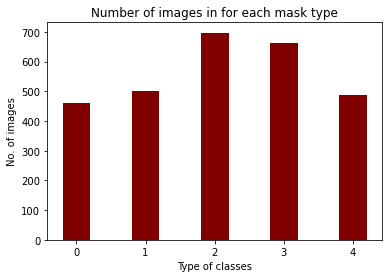

0  :  Cloth_Mask - 461  images
1  :  N95_Mask - 501  images
2  :  N95_Mask_With_Valve - 697  images
3  :  No_Face_Mask - 662  images
4  :  Surgical_Mask - 487  images


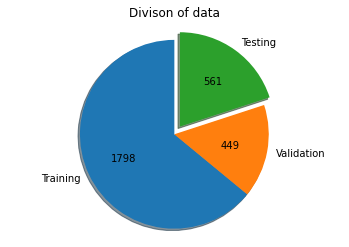

In [497]:
data_train_loader, data_validation_loader ,data_test_loader, class_labels_dict, class_names = data_loader(dataSet_Path,32,0.2,0.2)

In [466]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,50),
            nn.Linear(50,4)

        )

    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

In [467]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [468]:
model = CNN().to(device)

if use_saved_model:
    model.load_state_dict(torch.load("CNN.model"),strict=False)

In [469]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [470]:
complete_training_loss_list = []
complete_validation_loss_list = []
accuracy_list = []

if not use_saved_model:

    for e in tqdm_notebook(range(epochs) , desc = "Epochs Completed : "):
        model.train()
        loss_training = 0
        for i, (images,labels) in enumerate(data_train_loader):
            outputs = model(images.to(device))
            model.zero_grad()
            loss_training = criterion(outputs,labels.to(device))
            loss_training.backward()
            optimizer.step()
        complete_training_loss_list.append(loss_training)

        model.eval()
        loss_validation=0

        correct = 0
        total = 0
        for i, (images,labels) in enumerate(data_validation_loader):
            with torch.no_grad():
                outputs = model(images.to(device))
                total += len(labels)
                _, predicted = torch.max(outputs.data,1)
                correct += (predicted == labels).sum().item()
                loss_validation = criterion(outputs,labels.to(device))
        complete_validation_loss_list.append(loss_validation)
        accuracy = (correct/total)* 100
        accuracy_list.append(accuracy)
        print('*** Epoch : {} *** \n Training Loss : {:.5f} - Validation Loss : {:.5f} - Accuracy on Validation Data : {:.2f}\n'.format(e+1,loss_training,loss_validation , accuracy))

Epochs Completed :   0%|          | 0/30 [00:00<?, ?it/s]

*** Epoch : 1 *** 
 Training Loss : 3.84382 - Validation Loss : 0.38388 - Accuracy on Validation Data : 44.99

*** Epoch : 2 *** 
 Training Loss : 0.30030 - Validation Loss : 0.18202 - Accuracy on Validation Data : 53.01

*** Epoch : 3 *** 
 Training Loss : 0.09811 - Validation Loss : 0.30183 - Accuracy on Validation Data : 55.46

*** Epoch : 4 *** 
 Training Loss : 0.03078 - Validation Loss : 0.06746 - Accuracy on Validation Data : 52.34

*** Epoch : 5 *** 
 Training Loss : 0.04074 - Validation Loss : 0.02398 - Accuracy on Validation Data : 57.46

*** Epoch : 6 *** 
 Training Loss : 0.03917 - Validation Loss : 0.07111 - Accuracy on Validation Data : 63.03

*** Epoch : 7 *** 
 Training Loss : 0.50016 - Validation Loss : 0.04696 - Accuracy on Validation Data : 59.91

*** Epoch : 8 *** 
 Training Loss : 0.19807 - Validation Loss : 0.51057 - Accuracy on Validation Data : 68.15

*** Epoch : 9 *** 
 Training Loss : 0.02031 - Validation Loss : 0.03015 - Accuracy on Validation Data : 71.27

*

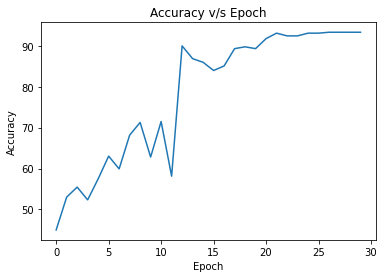

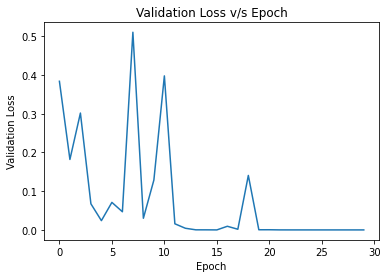

In [481]:
if not use_saved_model:

    torch.save(model.state_dict(), "CNN.model")
    plt.plot(accuracy_list)
    plt.title('Accuracy v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(complete_validation_loss_list)
    plt.title('Validation Loss v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.show()



In [472]:
predicted_labels = []
correct_labels = []
total = 0

correct_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for  i,(images,labels) in enumerate(data_test_loader):
        outputs = model(images.to(device))
        outputs = torch.argmax(F.softmax(outputs),dim=1)
        if predicted_labels==[]:
            correct_labels=labels[:];
            predicted_labels = outputs[:]

        else:

            correct_labels = torch.hstack([correct_labels,labels])
            predicted_labels = torch.hstack([predicted_labels,outputs])


/var/folders/5s/c7pshfq90w9ccjykz9kg_yfw0000gn/T/ipykernel_85093/1305195751.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.argmax(F.softmax(outputs),dim=1)


                     precision    recall  f1-score   support

         Cloth_Mask       0.92      0.84      0.88        85
           N95_Mask       0.89      0.90      0.89        98
N95_Mask_With_Valve       0.92      0.91      0.91       149
       No_Face_Mask       0.87      0.94      0.90       119
      Surgical_Mask       0.98      0.97      0.98       110

           accuracy                           0.91       561
          macro avg       0.92      0.91      0.91       561
       weighted avg       0.92      0.91      0.91       561



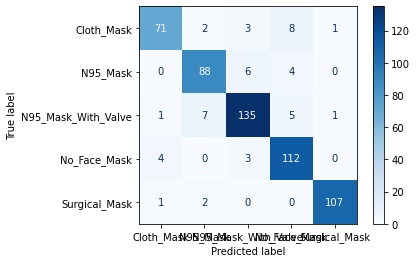

0  :  Cloth_Mask
1  :  N95_Mask
2  :  N95_Mask_With_Valve
3  :  No_Face_Mask
4  :  Surgical_Mask


In [489]:
target_names = class_names
labels_names = [0,1,2,3,4]
print(classification_report(correct_labels, predicted_labels,labels=labels_names, target_names=target_names))
cm = confusion_matrix(correct_labels, predicted_labels,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()
for i in class_labels_dict.keys():
    print(i ," : " , class_labels_dict[i])